# 1. Data Preparation and QC

* Normalize VCF files using tools like bcftools norm
* Select manageable genomic regions (e.g., chr22) for prototyping
* Convert VCF into a tabular/structured format (e.g., NumPy, Pandas, tensors)

**Bioinformatics tools**:
* pyVCF/pysam/cyvcf2
* bcftools
* plink2
* scikit-allel
* vcfpy

In [1]:
from data.data_utils import *
from tqdm import tqdm

# Define global information
figures_datapath = "figures/source_data/"
SOURCE_DATA_DIR = 'data/sources/1000GP/'

## 1.a. Sample lookup from 1000GP ste

In [ ]:
ftp_files = pd.read_csv(f"{SOURCE_DATA_DIR}current.tree", sep="\t", header=None)
phase3_files = ftp_files[ftp_files[0].str.contains("phase3")]
print(phase3_files.shape)
phase3_files.head()

(289187, 6)


,0,1,2,3,4,5
1353,ftp/phase3/data/NA12004/sequence_read/ERR00209...,file,278380554,2015-05-01 00:08:25,a5edcec6a6268cd3a218d86b2704d2cb,NaN
1354,ftp/phase3/data/NA12004/sequence_read/ERR00071...,file,337010895,2015-05-01 21:39:37,13963fd505cdb94b6bca3094569bb87b,NaN
1355,ftp/phase3/data/NA12004/sequence_read/ERR00209...,file,290641669,2015-05-01 22:16:31,44ed6851ed0a901a45e8e0f7675d2879,NaN
1356,ftp/phase3/data/NA12004/sequence_read/ERR00071...,file,304378028,2015-05-01 00:13:54,9b31cf2eea94856557be63c4e33dd1ac,NaN
1357,ftp/phase3/data/NA12004/sequence_read/ERR00209...,file,280937967,2015-05-01 23:42:57,88ccf9f1ebd0a4db6c7963b5af31bb5d,NaN


In [ ]:
samples_info = pd.read_excel(get_data_dir('1000gp', type='info'))
sample_names = samples_info["Sample"].to_list()

# Create a lookup for sample names and corresponding filepaths in phase3_files
sample_lookup = {name: [] for name in sample_names}
found_samples = []

for name in sample_names:
    df_id = 0
    found = False
    while (name not in phase3_files.iloc[df_id][0]) and (df_id < phase3_files.shape[0]-1):
        df_id += 1
    if df_id == phase3_files.shape[0] - 1:
            print(f"Sample {name} not found in phase3_files.")
            continue
    else:
        print(f"Found {name} at index {df_id}")
        found_samples.append(name)
        while name in phase3_files.iloc[df_id][0]:
            # print(phase3_files.iloc[df_id][0])
            sample_lookup[name].append(phase3_files.iloc[df_id][0])
            df_id += 1

len(found_samples), found_samples, sample_lookup

Found HG00096 at index 38270
Found HG00097 at index 36653
Sample HG00098 not found in phase3_files.
Found HG00099 at index 36734
Found HG00100 at index 34680
Found HG00101 at index 42592
Found HG00102 at index 43945
Found HG00103 at index 38210
Found HG00104 at index 36602
Found HG00105 at index 21450
Found HG00106 at index 35612
Found HG00107 at index 54474
Found HG00108 at index 41675
Found HG00109 at index 42772
Found HG00110 at index 41795
Found HG00111 at index 41735
Found HG00112 at index 21413
Found HG00113 at index 42589
Found HG00114 at index 34854
Found HG00115 at index 39092
Found HG00116 at index 21872
Found HG00117 at index 35925
Found HG00118 at index 34580
Found HG00119 at index 36073
Found HG00120 at index 35916
Found HG00121 at index 41798
Found HG00122 at index 34710
Found HG00123 at index 36082
Found HG00124 at index 21472
Found HG00125 at index 36881
Found HG00126 at index 34713
Found HG00127 at index 38261
Found HG00128 at index 36611
Found HG00129 at index 37946
F

(2736,
 ['HG00096',
  'HG00097',
  'HG00099',
  'HG00100',
  'HG00101',
  'HG00102',
  'HG00103',
  'HG00104',
  'HG00105',
  'HG00106',
  'HG00107',
  'HG00108',
  'HG00109',
  'HG00110',
  'HG00111',
  'HG00112',
  'HG00113',
  'HG00114',
  'HG00115',
  'HG00116',
  'HG00117',
  'HG00118',
  'HG00119',
  'HG00120',
  'HG00121',
  'HG00122',
  'HG00123',
  'HG00124',
  'HG00125',
  'HG00126',
  'HG00127',
  'HG00128',
  'HG00129',
  'HG00130',
  'HG00131',
  'HG00132',
  'HG00133',
  'HG00136',
  'HG00137',
  'HG00138',
  'HG00139',
  'HG00140',
  'HG00141',
  'HG00142',
  'HG00143',
  'HG00145',
  'HG00146',
  'HG00148',
  'HG00149',
  'HG00150',
  'HG00151',
  'HG00154',
  'HG00155',
  'HG00157',
  'HG00158',
  'HG00159',
  'HG00160',
  'HG00171',
  'HG00173',
  'HG00174',
  'HG00176',
  'HG00177',
  'HG00178',
  'HG00179',
  'HG00180',
  'HG00181',
  'HG00182',
  'HG00183',
  'HG00185',
  'HG00186',
  'HG00187',
  'HG00188',
  'HG00189',
  'HG00190',
  'HG00231',
  'HG00232',
  'HG

In [ ]:
# Save the sample lookup dictionary to a CSV file
filepath = f'{SOURCE_DATA_DIR}sample_lookup.csv'
f = open(filepath,'w')
for key, value in sample_lookup.items():
    if isinstance(value, list):
        value = ', '.join(value)
    f.write(f"{key}, {value}\n")
f.close()
print(f"Saved data to {filepath}")

Saved data to data/sources/1000GP/sample_lookup.csv


In [ ]:
filepath = f'{SOURCE_DATA_DIR}sample_lookup.csv'
populations = pd.read_excel(get_data_dir('1000gp', type='info'))
super_populations = pd.read_csv('sources/1000GP/populations.tsv', sep="\t")
with open(filepath, 'w') as f:
    f.write("Sample\tPopulation\tSuperpopulation\tRelationship\n")
    for i,rec in populations.iterrows():
        super_pop = super_populations[super_populations['Population Code'] == rec['Population']]['Super Population'].values[0]
        f.write(f"{rec['Sample']}\t{rec['Population']}\t{super_pop}\t{rec['Relationship']}\n")

print(f"Saved data to {filepath}")

Saved data to data/sources/1000GP/sample_lookup.csv


In [2]:
sample_info = pd.read_csv('data/sources/1000GP/sample_lookup.csv', sep="\t")
sample_superpop = {}
for superpop in sample_info['Superpopulation'].unique():
    print(f"Superpopulation: {superpop}", end=' ')
    sample_superpop[superpop] = sample_info[sample_info['Superpopulation'] == superpop]['Sample'].to_list()
    print(f" > Samples: {len(sample_superpop[superpop])}")

Superpopulation: EUR  > Samples: 669
Superpopulation: EAS  > Samples: 617
Superpopulation: AMR  > Samples: 535
Superpopulation: SAS  > Samples: 661
Superpopulation: AFR  > Samples: 1018


___
## 1.b. Chromosome 22 Dataset

### Rare mutation selection

Randdomly select common (95%) and rare (5%) mutations to make up a (subset of the) total genome.

In [13]:
# clean rare mutations
with open('data/sources/rare_snps.txt') as f:
    rare_snps = f.read().splitlines()

cleaned_snps = []
to_delete = 0
for snp in rare_snps:
    if '<' not in snp:
        cleaned_snps.append(snp)
    else:
        to_delete += 1

print(f"Deleted {to_delete} invalid SNPs. Kept {len(cleaned_snps)}.")

with open('data/sources/rare_snps.txt', 'w+') as f:
    for snp in cleaned_snps:
        f.writelines(f'{snp}\n')
# 991105

Deleted 721 invalid SNPs. Kept 991981.


In [ ]:
# clean common mutations
with open('data/sources/common_snps.txt') as f:
    common_snps = f.read().splitlines()

cleaned_snps = []
to_delete = 0
for snp in common_snps:
    if '<CN' not in snp:
        cleaned_snps.append(snp)
    else:
        to_delete += 1

print(f"Deleted {to_delete} invalid SNPs. Kept {len(cleaned_snps)}.")

with open('data/sources/common_snps.txt', 'w+') as f:
    for snp in cleaned_snps:
        f.writelines(f'{snp}\n')
# 991105

Deleted 70 invalid SNPs. Kept 112485.


In [14]:
import random

def create_mutation_list(total_muts_number = 'all',
                        common_file = 'data/sources/common_snps.txt',
                        rare_file = 'data/sources/rare_snps.txt',
                        output_file = 'data/sources/all_snps.txt',):
    
    def calculate_freq_impact(common, rare):
        total = common + rare # 115139 + 990118
        # print(total, 1103547)
        if total == 0:
            return 0, 0
        return common / total, rare / total

    def get_muts_by_frequency(mutations_list, pop_frequency, subset_muts):
        if subset_muts != 'all':
            assert isinstance(subset_muts, int), "subset_muts must be an integer."
            num_to_keep = int(subset_muts * pop_frequency)
        else:
            num_to_keep = int(len(mutations_list) * pop_frequency)
        chosen_muts = random.sample(mutations_list, num_to_keep)
        return chosen_muts

    with open(common_file) as f:
        common_snps = f.read().splitlines()

    with open(rare_file) as f:
        rare_snps = f.read().splitlines()

    common_freq, rare_freq = calculate_freq_impact(len(common_snps),
                                                   len(rare_snps))
    print(f"Common mutations frequency: {common_freq:.4f}, Rare mutations frequency: {rare_freq:.4f}")

    chosen_rare = get_muts_by_frequency(rare_snps, rare_freq, total_muts_number)  # 5% of the total genome
    chosen_common = get_muts_by_frequency(common_snps, common_freq, total_muts_number)  # 95% of the total genome

    # Combine
    # all_snps = list(set(chosen_common + chosen_rare))
    all_snps = chosen_common + chosen_rare

    with open(output_file, 'w+') as f:
        for snp in all_snps:
            f.writelines(f'{snp}\n')

    print(f"Created mutation list with {len(all_snps)} mutations: {len(chosen_common)} common and {len(chosen_rare)} rare.")

    return all_snps

all_snps = create_mutation_list()

Common mutations frequency: 0.1018, Rare mutations frequency: 0.8982
Created mutation list with 902408 mutations: 11456 common and 890952 rare.


In [15]:
all_snps = create_mutation_list(total_muts_number=100001, output_file='data/sources/100000_snps.txt',)

Common mutations frequency: 0.1018, Rare mutations frequency: 0.8982
Created mutation list with 100000 mutations: 10184 common and 89816 rare.


In [16]:
all_snps = create_mutation_list(total_muts_number=10001, output_file='data/sources/10000_snps.txt',)

Common mutations frequency: 0.1018, Rare mutations frequency: 0.8982
Created mutation list with 10000 mutations: 1018 common and 8982 rare.


In [17]:
all_snps = create_mutation_list(total_muts_number=1001, output_file='data/sources/1000_snps.txt',)

Common mutations frequency: 0.1018, Rare mutations frequency: 0.8982
Created mutation list with 1000 mutations: 101 common and 899 rare.


___

In [1]:
from data.data_utils import *

In [2]:
chrom = 22

for num_muts, data_size in zip([1000, 10000], ['small', 'medium']):
    dataset = f'/Volumes/asia_2T/genomics/reference/1000GP/corpus/{data_size}/filtered_{num_muts}snps.vcf.gz'
    save_path=f'data/sources/json/{data_size}/genotypes_{num_muts}_chr{chrom}.json'

    vcf_file = get_VCF_file(dataset, chr=chrom, sample_ids=None, flags='H', zip=True)
    test_corpus_dict = vcf_to_sequential(vcf_file, mutations_file=f'data/sources/{data_size}/{num_muts}_snps.txt', 
                                        dataset=dataset, sample_ids='all', mutations='all',
                        chr=chrom, flags='H', save=True, save_path=save_path)
    print(f"Saved {len(test_corpus_dict)} samples with {len(test_corpus_dict)} mutations at {save_path}.\n")

2504 available samples in the VCF file.


Processing VCF records: 1176it [00:06, 191.47it/s]


Processed 1006 mutations for 2504 samples.
Saved 2504 samples with 2504 mutations at data/sources/json/small/genotypes_1000_chr22.json.

2504 available samples in the VCF file.


Processing VCF records: 10529it [05:02, 34.83it/s]


Processed 10061 mutations for 2504 samples.
Saved 2504 samples with 2504 mutations at data/sources/json/medium/genotypes_10000_chr22.json.



In [3]:
for name,num_muts in zip(['small', 'medium'],[1000, 10000]):
    dataset = f'data/sources/json/{name}/genotypes_{num_muts}_chr{chrom}.json'
    new_dataset = f'data/sources/json/{name}/genotypes_{name}_chr{chrom}.json'

    with open(dataset, 'r') as f:
        old_corpus = json.load(f)
    print(old_corpus[list(old_corpus.keys())[0]][:50])
    new_corpus = {k:{
        'genotypes': old_corpus[k]
    } for k in old_corpus.keys()}
    with open(new_dataset, 'w+') as f:
        json.dump(new_corpus, f)
    print(f"Saved reformatted {len(new_corpus)} samples with {len(new_corpus[list(new_corpus.keys())[0]]['genotypes'])} mutations at {new_dataset}.\n")

 22:16077355:A>T_0|0 22:16114297:A>T_0|0 22:164021
Saved reformatted 2504 samples with 20284 mutations at data/sources/json/small/genotypes_small_chr22.json.

 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:160596
Saved reformatted 2504 samples with 203155 mutations at data/sources/json/medium/genotypes_medium_chr22.json.



___

In [ ]:
dataset = '1000gp'
chrom = 22
save_path=f'sources/test/test_corpus_chr{chrom}.json'

vcf_file = get_VCF_file(dataset, chr=chrom, sample_ids=None, flags='H', zip=True)
test_corpus_dict = vcf_to_sequential(vcf_file, dataset, sample_ids=1000, mutations=1000,
                      chr=chrom, flags='H', save=True, save_path=save_path)
print(f"Saved {len(test_corpus_dict)} samples with {len(test_corpus_dict)} mutations at {save_path}.")

Processing VCF records: 1095455it [00:55, 19834.23it/s]
Processed 1000 mutations for 823 samples.
Saved 823 samples with 823 mutations at sources/test/test_corpus_chr22.json.


In [ ]:
# Final dataset for chromosome 22 (for training)
DATA_PATH = '/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_22/chr22_'
full_dataset_chr22 = {}
for superpop in sample_info['Superpopulation'].unique():
    sp_chr22_dataset = f'{DATA_PATH}{superpop}.json'
    print(f"Loading dataset for {superpop} from {sp_chr22_dataset}")
    with open(sp_chr22_dataset, 'r') as f:
        chr_gts = json.load(f)
    
    sample_ids = list(chr_gts.keys())
    for sample_gts in sample_ids:
        if sample_gts not in list(full_dataset_chr22.keys()):
            print(f"Adding sample {sample_gts} to full dataset.")
            # prepend superpopulation info to the genotype sequences
            # full_dataset_chr22[sample] = f'{superpop}'
            full_dataset_chr22[sample_gts] = ''
        full_dataset_chr22[sample_gts] += chr_gts[sample_gts]
        # print(f"Loaded {len(full_dataset_chr22[sample])} muts for {sample}.")

with open('/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22.json', 'w') as f:
# with open('data/sources/json/corpus_chr22.json', 'w') as f:
    json.dump(full_dataset_chr22, f, indent=4)

Loading dataset for EUR from /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_EUR.json
Adding sample HG00096 to full dataset.
Adding sample HG00097 to full dataset.
Adding sample HG00099 to full dataset.
Adding sample HG00100 to full dataset.
Adding sample HG00101 to full dataset.
Adding sample HG00102 to full dataset.
Adding sample HG00103 to full dataset.
Adding sample HG00105 to full dataset.
Adding sample HG00106 to full dataset.
Adding sample HG00107 to full dataset.
Adding sample HG00108 to full dataset.
Adding sample HG00109 to full dataset.
Adding sample HG00110 to full dataset.
Adding sample HG00111 to full dataset.
Adding sample HG00112 to full dataset.
Adding sample HG00113 to full dataset.
Adding sample HG00114 to full dataset.
Adding sample HG00115 to full dataset.
Adding sample HG00116 to full dataset.
Adding sample HG00117 to full dataset.
Adding sample HG00118 to full dataset.
Adding sample HG00119 to full dataset.
Adding sample HG00120 to full dataset.
Adding sa

In [ ]:
# Final dataset for chromosome 22 (with population code)
full_dataset_chr22 = {}
for superpop in sample_info['Superpopulation'].unique():
    sp_chr22_dataset = f'{DATA_PATH}{superpop}.json'
    print(f"Loading dataset for {superpop} from {sp_chr22_dataset}")
    with open(sp_chr22_dataset, 'r') as f:
        chr_gts = json.load(f)
    
    sample_ids = list(chr_gts.keys())
    for sample_gts in sample_ids:
        if sample_gts not in list(full_dataset_chr22.keys()):
            print(f"Adding sample {sample_gts} to full dataset.")
            # prepend superpopulation info to the genotype sequences
            full_dataset_chr22[sample_gts] = f'<superpop>{superpop}</superpop>'
        full_dataset_chr22[sample_gts] += chr_gts[sample_gts]
        # print(f"Loaded {len(full_dataset_chr22[sample])} muts for {sample}.")

with open('/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_with_superpop.json', 'w') as f:
    json.dump(full_dataset_chr22, f, indent=4)

Loading dataset for EUR from /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_22/chr22_EUR.json
Adding sample HG00096 to full dataset.
Adding sample HG00097 to full dataset.
Adding sample HG00099 to full dataset.
Adding sample HG00100 to full dataset.
Adding sample HG00101 to full dataset.
Adding sample HG00102 to full dataset.
Adding sample HG00103 to full dataset.
Adding sample HG00105 to full dataset.
Adding sample HG00106 to full dataset.
Adding sample HG00107 to full dataset.
Adding sample HG00108 to full dataset.
Adding sample HG00109 to full dataset.
Adding sample HG00110 to full dataset.
Adding sample HG00111 to full dataset.
Adding sample HG00112 to full dataset.
Adding sample HG00113 to full dataset.
Adding sample HG00114 to full dataset.
Adding sample HG00115 to full dataset.
Adding sample HG00116 to full dataset.
Adding sample HG00117 to full dataset.
Adding sample HG00118 to full dataset.
Adding sample HG00119 to full dataset.
Adding sample HG00120 to full dataset.
Ad

In [ ]:
sample_info = pd.read_csv('data/sources/1000GP/sample_lookup.csv', sep="\t")
# Final dataset for chromosome 22 (for training)
DATA_PATH = '/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_22/chr22_'
full_dataset_chr22 = {}
for superpop in sample_info['Superpopulation'].unique():
    sp_chr22_dataset = f'{DATA_PATH}{superpop}.json'
    print(f"Loading dataset for {superpop} from {sp_chr22_dataset}")
    with open(sp_chr22_dataset, 'r') as f:
        chr_gts = json.load(f)
    
    sample_ids = list(chr_gts.keys())
    for sample_gts in tqdm(sample_ids):
        if sample_gts not in list(full_dataset_chr22.keys()):
            print(f"Adding sample {sample_gts} to full dataset.")
            # prepend superpopulation info to the genotype sequences
            # full_dataset_chr22[sample] = f'{superpop}'
            full_dataset_chr22[sample_gts] = ''
        full_dataset_chr22[sample_gts] += chr_gts[sample_gts]
        # print(f"Loaded {len(full_dataset_chr22[sample])} muts for {sample}.")

with open('/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22.json', 'w+') as f:
# with open('data/sources/json/corpus_chr22.json', 'w') as f:
    json.dump(full_dataset_chr22, f, indent=4)

Loading dataset for EUR from /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_22/chr22_EUR.json


100%|██████████| 503/503 [00:00<00:00, 85995.80it/s]


Adding sample HG00096 to full dataset.
Adding sample HG00097 to full dataset.
Adding sample HG00099 to full dataset.
Adding sample HG00100 to full dataset.
Adding sample HG00101 to full dataset.
Adding sample HG00102 to full dataset.
Adding sample HG00103 to full dataset.
Adding sample HG00105 to full dataset.
Adding sample HG00106 to full dataset.
Adding sample HG00107 to full dataset.
Adding sample HG00108 to full dataset.
Adding sample HG00109 to full dataset.
Adding sample HG00110 to full dataset.
Adding sample HG00111 to full dataset.
Adding sample HG00112 to full dataset.
Adding sample HG00113 to full dataset.
Adding sample HG00114 to full dataset.
Adding sample HG00115 to full dataset.
Adding sample HG00116 to full dataset.
Adding sample HG00117 to full dataset.
Adding sample HG00118 to full dataset.
Adding sample HG00119 to full dataset.
Adding sample HG00120 to full dataset.
Adding sample HG00121 to full dataset.
Adding sample HG00122 to full dataset.
Adding sample HG00123 to 

100%|██████████| 504/504 [00:00<00:00, 56879.57it/s]


Adding sample HG00403 to full dataset.
Adding sample HG00404 to full dataset.
Adding sample HG00406 to full dataset.
Adding sample HG00407 to full dataset.
Adding sample HG00409 to full dataset.
Adding sample HG00410 to full dataset.
Adding sample HG00419 to full dataset.
Adding sample HG00421 to full dataset.
Adding sample HG00422 to full dataset.
Adding sample HG00428 to full dataset.
Adding sample HG00436 to full dataset.
Adding sample HG00437 to full dataset.
Adding sample HG00442 to full dataset.
Adding sample HG00443 to full dataset.
Adding sample HG00445 to full dataset.
Adding sample HG00446 to full dataset.
Adding sample HG00448 to full dataset.
Adding sample HG00449 to full dataset.
Adding sample HG00451 to full dataset.
Adding sample HG00452 to full dataset.
Adding sample HG00457 to full dataset.
Adding sample HG00458 to full dataset.
Adding sample HG00463 to full dataset.
Adding sample HG00464 to full dataset.
Adding sample HG00472 to full dataset.
Adding sample HG00473 to 

100%|██████████| 347/347 [00:00<00:00, 50561.87it/s]


Adding sample HG00551 to full dataset.
Adding sample HG00553 to full dataset.
Adding sample HG00554 to full dataset.
Adding sample HG00637 to full dataset.
Adding sample HG00638 to full dataset.
Adding sample HG00640 to full dataset.
Adding sample HG00641 to full dataset.
Adding sample HG00731 to full dataset.
Adding sample HG00732 to full dataset.
Adding sample HG00734 to full dataset.
Adding sample HG00736 to full dataset.
Adding sample HG00737 to full dataset.
Adding sample HG00739 to full dataset.
Adding sample HG00740 to full dataset.
Adding sample HG00742 to full dataset.
Adding sample HG00743 to full dataset.
Adding sample HG01047 to full dataset.
Adding sample HG01048 to full dataset.
Adding sample HG01049 to full dataset.
Adding sample HG01051 to full dataset.
Adding sample HG01052 to full dataset.
Adding sample HG01054 to full dataset.
Adding sample HG01055 to full dataset.
Adding sample HG01058 to full dataset.
Adding sample HG01060 to full dataset.
Adding sample HG01061 to 

100%|██████████| 489/489 [00:00<00:00, 37034.63it/s]


Adding sample HG01583 to full dataset.
Adding sample HG01586 to full dataset.
Adding sample HG01589 to full dataset.
Adding sample HG01593 to full dataset.
Adding sample HG02490 to full dataset.
Adding sample HG02491 to full dataset.
Adding sample HG02493 to full dataset.
Adding sample HG02494 to full dataset.
Adding sample HG02597 to full dataset.
Adding sample HG02600 to full dataset.
Adding sample HG02601 to full dataset.
Adding sample HG02603 to full dataset.
Adding sample HG02604 to full dataset.
Adding sample HG02648 to full dataset.
Adding sample HG02649 to full dataset.
Adding sample HG02651 to full dataset.
Adding sample HG02652 to full dataset.
Adding sample HG02654 to full dataset.
Adding sample HG02655 to full dataset.
Adding sample HG02657 to full dataset.
Adding sample HG02658 to full dataset.
Adding sample HG02660 to full dataset.
Adding sample HG02661 to full dataset.
Adding sample HG02681 to full dataset.
Adding sample HG02682 to full dataset.
Adding sample HG02684 to 

100%|██████████| 661/661 [00:00<00:00, 28886.45it/s]


Adding sample HG01879 to full dataset.
Adding sample HG01880 to full dataset.
Adding sample HG01882 to full dataset.
Adding sample HG01883 to full dataset.
Adding sample HG01885 to full dataset.
Adding sample HG01886 to full dataset.
Adding sample HG01889 to full dataset.
Adding sample HG01890 to full dataset.
Adding sample HG01894 to full dataset.
Adding sample HG01896 to full dataset.
Adding sample HG01912 to full dataset.
Adding sample HG01914 to full dataset.
Adding sample HG01915 to full dataset.
Adding sample HG01956 to full dataset.
Adding sample HG01958 to full dataset.
Adding sample HG01985 to full dataset.
Adding sample HG01986 to full dataset.
Adding sample HG01988 to full dataset.
Adding sample HG01989 to full dataset.
Adding sample HG01990 to full dataset.
Adding sample HG02009 to full dataset.
Adding sample HG02010 to full dataset.
Adding sample HG02012 to full dataset.
Adding sample HG02013 to full dataset.
Adding sample HG02014 to full dataset.
Adding sample HG02051 to 

In [2]:
chr22_gts = get_sequences_from_file('/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22.json')

In [ ]:
def get_sample_wise_mut_list(genotypes):
    sample_gts = []
    for sample in tqdm(genotypes):
        sample_gts.append([mut for mut in sample.split(' ') if mut != ''])

    return sample_gts

chr22_gts_list = get_sample_wise_mut_list(chr22_gts)

with open('data/sources/json/chr22_2504_samples.json', 'x') as f:
    json.dump(chr22_gts_list, f)

100%|██████████| 1780/1780 [01:18<00:00, 22.79it/s]


___
## 1.c. All Chromosomes Dataset

In [ ]:
# small dataset with all chromosomes
dataset = '1000gp'
for chrom in range(1, 23):
    print(f"Processing chromosome {chrom}...")
    save_path = get_data_dir(dataset=dataset, type='data', flags='') + f'corpus/corpus_chr{chrom}.json'
    vcf_file = get_VCF_file(dataset, chr=chrom, sample_ids=None, flags='H', zip=True)
    test_corpus_dict = vcf_to_sequential(vcf_file, dataset, sample_ids=1000, mutations=1000,
                        chr=chrom, flags='H', save=True, save_path=save_path)
    print(f"Saved {len(test_corpus_dict)} samples with {len(test_corpus_dict)} mutations at {save_path}.")

Processing chromosome 1...


Processing VCF records: 6149041it [05:05, 20138.21it/s]         


Processed 1000 mutations for 814 samples.
Saved 814 samples with 814 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr1.json.
Processing chromosome 2...


Processing VCF records: 6710271it [05:36, 19966.76it/s]         


Processed 1000 mutations for 835 samples.
Saved 835 samples with 835 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr2.json.
Processing chromosome 3...


Processing VCF records: 5615340it [04:38, 20140.70it/s]         


Processed 1000 mutations for 827 samples.
Saved 827 samples with 827 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr3.json.
Processing chromosome 4...


Processing VCF records: 5411645it [04:28, 20179.35it/s]         


Processed 1000 mutations for 830 samples.
Saved 830 samples with 830 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr4.json.
Processing chromosome 5...


Processing VCF records: 5069207it [04:10, 20256.07it/s]         


Processed 1000 mutations for 844 samples.
Saved 844 samples with 844 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr5.json.
Processing chromosome 6...


Processing VCF records: 4832674it [04:00, 20082.82it/s]                     


Processed 1000 mutations for 851 samples.
Saved 851 samples with 851 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr6.json.
Processing chromosome 7...


Processing VCF records: 4691977it [03:50, 20335.01it/s]         


Processed 1000 mutations for 819 samples.
Saved 819 samples with 819 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr7.json.
Processing chromosome 8...


Processing VCF records: 4588755it [03:45, 20312.25it/s]                     


Processed 1000 mutations for 839 samples.
Saved 839 samples with 839 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr8.json.
Processing chromosome 9...


Processing VCF records: 3548896it [02:54, 20335.62it/s]                     


Processed 1000 mutations for 838 samples.
Saved 838 samples with 838 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr9.json.
Processing chromosome 10...


Processing VCF records: 3985351it [03:24, 19506.22it/s]         


Processed 1000 mutations for 820 samples.
Saved 820 samples with 820 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr10.json.
Processing chromosome 11...


Processing VCF records: 4038232it [03:21, 20086.76it/s]                 


Processed 1000 mutations for 814 samples.
Saved 814 samples with 814 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr11.json.
Processing chromosome 12...


Processing VCF records: 3844163it [03:10, 20185.85it/s]         


Processed 1000 mutations for 836 samples.
Saved 836 samples with 836 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr12.json.
Processing chromosome 13...


Processing VCF records: 2850948it [02:22, 20074.29it/s]         


Processed 1000 mutations for 830 samples.
Saved 830 samples with 830 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr13.json.
Processing chromosome 14...


Processing VCF records: 2644841it [02:12, 20031.62it/s]         


Processed 1000 mutations for 821 samples.
Saved 821 samples with 821 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr14.json.
Processing chromosome 15...


Processing VCF records: 2409490it [02:00, 19954.40it/s]                     


Processed 1000 mutations for 828 samples.
Saved 828 samples with 828 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr15.json.
Processing chromosome 16...


Processing VCF records: 2682998it [02:11, 20409.93it/s]                     


Processed 1000 mutations for 826 samples.
Saved 826 samples with 826 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr16.json.
Processing chromosome 17...


Processing VCF records: 2325643it [01:57, 19860.10it/s]                     


Processed 1000 mutations for 804 samples.
Saved 804 samples with 804 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr17.json.
Processing chromosome 18...


Processing VCF records: 2264472it [01:53, 19959.14it/s]         


Processed 1000 mutations for 814 samples.
Saved 814 samples with 814 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr18.json.
Processing chromosome 19...


Processing VCF records: 1830196it [01:32, 19784.29it/s]         


Processed 1000 mutations for 813 samples.
Saved 813 samples with 813 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr19.json.
Processing chromosome 20...


Processing VCF records: 1805981it [01:29, 20231.18it/s]         


Processed 1000 mutations for 825 samples.
Saved 825 samples with 825 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr20.json.
Processing chromosome 21...


Processing VCF records: 1102931it [00:56, 19619.63it/s]                     


Processed 1000 mutations for 836 samples.
Saved 836 samples with 836 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr21.json.
Processing chromosome 22...


Processing VCF records: 1093019it [00:56, 19512.25it/s]         


Processed 1000 mutations for 824 samples.
Saved 824 samples with 824 mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/corpus_chr22.json.


In [130]:
# FULL dataset
dataset = '1000gp'
chrom = 22
for superpop in sample_info['Superpopulation'].unique():
    sample_ids = sample_superpop[superpop]
    print(f"Processing {len(sample_ids)} samples for chromosome {chrom}...")
    save_path = get_data_dir(dataset=dataset, type='data', flags='') + f'corpus/chr{chrom}_{superpop}.json'
    vcf_file = get_VCF_file(dataset, chr=chrom, sample_ids=sample_ids, flags='H', zip=True)
    test_corpus_dict = vcf_to_sequential(vcf_file, dataset, sample_ids=sample_ids, mutations=100000,
                        chr=chrom, flags='H', save=True, save_path=save_path)
    print(f"Saved {len(test_corpus_dict)} samples mutations at {save_path}.")

Processing 669 samples for chromosome 22...


/Users/asiabelfiore/Desktop/london/UNI/Imperial/SEMESTERS/3-SUMMER/Thesis/experimentation/data/data_utils.py:304: UserWarning: not all requested samples found in VCF
  return VCF(filepath, gts012=True, samples=sample_ids)


Processing VCF records: 1101661it [2:42:41, 112.85it/s]                        


Processed 100000 mutations for 503 samples.
Saved 503 samples mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_EUR.json.
Processing 617 samples for chromosome 22...


/Users/asiabelfiore/Desktop/london/UNI/Imperial/SEMESTERS/3-SUMMER/Thesis/experimentation/data/data_utils.py:304: UserWarning: not all requested samples found in VCF
  return VCF(filepath, gts012=True, samples=sample_ids)
Processing VCF records: 1101154it [3:26:20, 88.95it/s]                         


Processed 100000 mutations for 504 samples.
Saved 504 samples mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_EAS.json.
Processing 535 samples for chromosome 22...


/Users/asiabelfiore/Desktop/london/UNI/Imperial/SEMESTERS/3-SUMMER/Thesis/experimentation/data/data_utils.py:304: UserWarning: not all requested samples found in VCF
  return VCF(filepath, gts012=True, samples=sample_ids)


Processing VCF records: 1101397it [3:02:42, 100.47it/s]                         


Processed 100000 mutations for 347 samples.
Saved 347 samples mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_AMR.json.
Processing 661 samples for chromosome 22...


/Users/asiabelfiore/Desktop/london/UNI/Imperial/SEMESTERS/3-SUMMER/Thesis/experimentation/data/data_utils.py:304: UserWarning: not all requested samples found in VCF
  return VCF(filepath, gts012=True, samples=sample_ids)


Processing VCF records: 1101057it [3:36:54, 84.60it/s]                         


Processed 100000 mutations for 489 samples.
Saved 489 samples mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_SAS.json.
Processing 1018 samples for chromosome 22...


/Users/asiabelfiore/Desktop/london/UNI/Imperial/SEMESTERS/3-SUMMER/Thesis/experimentation/data/data_utils.py:304: UserWarning: not all requested samples found in VCF
  return VCF(filepath, gts012=True, samples=sample_ids)


Processing VCF records: 1101333it [3:54:53, 78.14it/s]                         


Processed 100000 mutations for 661 samples.
Saved 661 samples mutations at /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr22_AFR.json.


In [ ]:
# Final dataset for ALL chromosomes
full_dataset_all_chroms = {}
for chr in range(1,23):
    chr_dataset = f'/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_ALL_small/corpus_chr{chr}.json'
    print(f"Loading dataset for {chr} from {chr_dataset}")
    with open(chr_dataset, 'r') as f:
        chr_gts = json.load(f)
    
    sample_ids = list(chr_gts.keys())
    for sample_gts in sample_ids:
        if sample_gts not in list(full_dataset_all_chroms.keys()):
            print(f"Adding sample {sample_gts} to full dataset.")
            full_dataset_all_chroms[sample_gts] = ''
        full_dataset_all_chroms[sample_gts] += (chr_gts[sample_gts].strip(sample_gts))
        # print(f"Loaded {len(full_dataset_all_chroms[sample])} muts for {sample}.")

with open('/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_ALL.json', 'w') as f:
    json.dump(full_dataset_all_chroms, f, indent=4)

Loading dataset for 1 from /Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_ALL_small/corpus_chr1.json
Adding sample HG00097 to full dataset.
Adding sample HG00101 to full dataset.
Adding sample HG00102 to full dataset.
Adding sample HG00113 to full dataset.
Adding sample HG00118 to full dataset.
Adding sample HG00122 to full dataset.
Adding sample HG00123 to full dataset.
Adding sample HG00126 to full dataset.
Adding sample HG00129 to full dataset.
Adding sample HG00130 to full dataset.
Adding sample HG00131 to full dataset.
Adding sample HG00132 to full dataset.
Adding sample HG00134 to full dataset.
Adding sample HG00135 to full dataset.
Adding sample HG00140 to full dataset.
Adding sample HG00143 to full dataset.
Adding sample HG00149 to full dataset.
Adding sample HG00150 to full dataset.
Adding sample HG00156 to full dataset.
Adding sample HG00157 to full dataset.
Adding sample HG00176 to full dataset.
Adding sample HG00183 to full dataset.
Adding sample HG00187 to full data

In [ ]:
all_chr_gts = get_sequences_from_file('/Volumes/asia_2T/genomics/reference/1000GP/corpus/chr_ALL.json')
valid_sequences, valid_seq_ratio, all_sequences = get_valid_sequences(all_chr_gts, sample_wise=True)

num_of_muts_per_sample = [len(i) for i in valid_sequences]

len(all_sequences), sum(num_of_muts_per_sample) / len(num_of_muts_per_sample), sum(valid_seq_ratio) / len(valid_seq_ratio)

(22000000, 8636.303185214314, 0.9981372960084475)

In [6]:
corpus_to_VCF(corpus='data/sources/test/test_corpus_small.json', 
            imputation_method='1000GPImputation',
            save=True, save_path='data/sources/vcfs/test_chr22_1000GP_small.vcf')

Gathering mutation information from corpus: 100%|██████████| 813/813 [00:01<00:00, 523.78it/s]


Found 998 unique mutations in 1 chromosomes.


Writing mutations to VCF: 998it [00:20, 49.69it/s]


Generated VCF saved to 'data/sources/vcfs/test_chr22_1000GP_small.vcf'.


'data/sources/vcfs/test_chr22_1000GP_small.vcf'

In [7]:
corpus_to_VCF(corpus='data/sources/test/test_corpus_chr22.json', 
            imputation_method='1000GPImputation',
            save=True, save_path='data/sources/vcfs/test_chr22_1000GP.vcf')

Gathering mutation information from corpus: 100%|██████████| 823/823 [00:01<00:00, 722.62it/s]


Found 1000 unique mutations in 1 chromosomes.


Writing mutations to VCF: 1000it [00:20, 48.10it/s]


Generated VCF saved to 'data/sources/vcfs/test_chr22_1000GP.vcf'.


'data/sources/vcfs/test_chr22_1000GP.vcf'

___

# 2. Train, Val and Holdout datasets creation

In [ ]:
from data.data_utils import *
from importlib import reload
import random
import pandas as pd
from tqdm import tqdm

POP_DIR = 'data/sources/1000GP/'
chrom = 22

In [5]:
popoulations = pd.read_csv(f'{POP_DIR}sample_lookup.csv', sep="\t")
pop_map = {pop: i for i, pop in enumerate(popoulations['Population'].unique())}
print(pop_map)

with open(f'{POP_DIR}population_map.json', 'w') as f:
    json.dump(pop_map, f)
print(f"Population map saved to {f'{POP_DIR}population_map.json'}")

{'GBR': 0, 'FIN': 1, 'CHS': 2, 'PUR': 3, 'CDX': 4, 'CLM': 5, 'IBS': 6, 'PEL': 7, 'PJL': 8, 'KHV': 9, 'ACB': 10, 'GWD': 11, 'ESN': 12, 'BEB': 13, 'MSL': 14, 'STU': 15, 'ITU': 16, 'CEU': 17, 'YRI': 18, 'CHB': 19, 'JPT': 20, 'LWK': 21, 'ASW': 22, 'MXL': 23, 'TSI': 24, 'GIH': 25}
Population map saved to data/sources/1000GP/population_map.json


In [ ]:
def split_json_dataset(dataset, ratio):
    sample_ids = dataset.keys()
    train_ids = random.sample(list(sample_ids), k=int(len(sample_ids) * (1 - ratio)))
    train_data = {id: dataset[id] for id in train_ids}
    val_data = {id: dataset[id] for id in sample_ids if id not in train_ids}
    return train_data, val_data

for dataset_size in ['small', 'medium']:
    SOURCE_DATA_DIR = f'data/sources/json/{dataset_size}/'
    with open(f'data/sources/json/{dataset_size}/genotypes_{dataset_size}_chr22.json', 'r') as f:
        data = json.load(f)
        
    corpus_formatted = {sample:{} for sample in data.keys()}
    for sample_gts, muts in tqdm(list(data.items())):
        corpus_formatted[sample_gts]['genotypes'] = muts['genotypes'] # ' '.join(muts)
        corpus_formatted[sample_gts]['population'] = popoulations.loc[popoulations['Sample'] == sample_gts, 'Population'].values[0]

    train_data, val_data = split_json_dataset(corpus_formatted, 0.3) # 70% training
    val_data, holdout_data = split_json_dataset(val_data, 0.5) # 15% validation, 15% holdout

    print(len(train_data), "training samples,", len(val_data), "validation samples,", len(holdout_data), "holdout samples")

    for data, file in zip([train_data, val_data, holdout_data], [f'{SOURCE_DATA_DIR}train_gts_with_pop.json', 
                                                          f'{SOURCE_DATA_DIR}val_gts_with_pop.json', 
                                                          f'{SOURCE_DATA_DIR}holdout_gts_with_pop.json']):
        with open(file, 'w+') as f:
            json.dump(data, f)

100%|██████████| 2504/2504 [00:00<00:00, 3631.70it/s]


1752 training samples, 376 validation samples, 376 holdout samples


100%|██████████| 2504/2504 [00:00<00:00, 4138.15it/s]


1752 training samples, 376 validation samples, 376 holdout samples


In [5]:
# Extract sample names split
for dataset_size in ['small', 'medium', 'large']:
    print(f"Processing {dataset_size} dataset...")
    SOURCE_DATA_DIR = f'data/sources/json/{dataset_size}/'
    sample_ids_map = {'train': [], 'val': [], 'holdout': []}

    for dataset_name, dataset in zip(('train', 'val', 'holdout'),
                    ([f'{SOURCE_DATA_DIR}train_gts_with_pop.json', 
                    f'{SOURCE_DATA_DIR}val_gts_with_pop.json', 
                    f'{SOURCE_DATA_DIR}holdout_gts_with_pop.json'])):
        with open(dataset, 'r') as f:
            data = json.load(f)
            sample_ids_map[dataset_name] = list(data.keys())

        print(f"    Loaded {len(data)} samples from {dataset_name}")

    with open(f'{SOURCE_DATA_DIR}sample_ids_per_dataset.json', 'w+') as f:
        json.dump(sample_ids_map, f)

Processing small dataset...
    Loaded 1752 samples from train
    Loaded 376 samples from val
    Loaded 376 samples from holdout
Processing medium dataset...
    Loaded 1752 samples from train
    Loaded 376 samples from val
    Loaded 376 samples from holdout
Processing large dataset...
    Loaded 1752 samples from train
    Loaded 376 samples from val
    Loaded 376 samples from holdout


___
## 2.b. High-risk profile genotypes

In [5]:
import json
import tqdm
import re

from data.data_utils import MUTATION_PATTERN, SEQUENCE_PATTERN

# get samples with most non-homo ref genotypes for rare variants
with open('data/sources/rare_snps.txt', 'r') as f:
    rare_snps = f.read().splitlines()
    rare_snps = [snp.rstrip('\n') for snp in rare_snps]

In [24]:
# Rare Genotypes (ALL)
for dataset_size in ['medium']:
    SOURCE_DATA_DIR = f'data/sources/json/{dataset_size}/'
    with open(f'data/sources/json/{dataset_size}/genotypes_{dataset_size}_chr22.json', 'r') as f:
        data = json.load(f)
        data = {k: v['genotypes'] for k, v in data.items()}
    
    sample_rare_genotypes = [re.findall(SEQUENCE_PATTERN, seq) for seq in data.values()]

    sample_names = list(data.keys())
    data_log = tqdm.tqdm(sample_rare_genotypes)
    rare_sample_gts = {sample_name: '' for sample_name in sample_names}
    for j, synth_sample in enumerate(data_log):
        data_log.set_description(desc=f"Calculating rare mutations for sample {j+1}")
        sample_rare_mutations = [mut.split('_')[0] for mut in synth_sample]
        common_muts = set(sample_rare_mutations).intersection(set(rare_snps))
        common_muts_with_gts = [mut for mut in synth_sample if mut.split('_')[0] in common_muts]
        rare_sample_gts[sample_names[j]] = ' '.join(list(common_muts_with_gts))

    with open(f'data/sources/json/{dataset_size}/all_rare_genotypes_{dataset_size}_chr22.json', 'w+') as f:
        json.dump(rare_sample_gts, f)

Calculating rare mutations for sample 273:  11%|█         | 273/2504 [00:17<02:14, 16.55it/s]

In [27]:
for sample, gt in rare_sample_gts.items():
    print(f"{sample}: {gt[:100]}... ({len(gt.split(' '))} mutations)")

HG00096: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00097: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00099: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00100: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00101: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00102: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00103: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 22:16061929:T>G_0|0 ... (8979 mutations)
HG00105: 22:16056839:C>T_0|0 22:16059249:G>A_0|0 22:16059670:A>G_0|0 22:16059958:G>T_0|0 2

In [ ]:
# Rare Genotypes (mutated only - no 0|0 genotypes)
for dataset_size in ['small', 'medium']:
    SOURCE_DATA_DIR = f'data/sources/json/{dataset_size}/'
    with open(f'data/sources/json/{dataset_size}/genotypes_{dataset_size}_chr22.json', 'r') as f:
        data = json.load(f)
        data = {k: v['genotypes'] for k, v in data.items()}
    
    sample_rare_genotypes = [re.findall(MUTATION_PATTERN, seq) for seq in data.values()]

    sample_names = list(data.keys())
    data_log = tqdm.tqdm(sample_rare_genotypes)
    rare_sample_gts = {sample_name: '' for sample_name in sample_names}
    for j, synth_sample in enumerate(data_log):
        data_log.set_description(desc=f"Calculating rare mutations for sample {j+1}")
        sample_rare_mutations = [mut.split('_')[0] for mut in synth_sample]
        common_muts = set(sample_rare_mutations).intersection(set(rare_snps))
        common_muts_with_gts = [mut for mut in synth_sample if mut.split('_')[0] in common_muts]
        rare_sample_gts[sample_names[j]] = ' '.join(list(common_muts_with_gts))

    with open(f'data/sources/json/{dataset_size}/rare_genotypes_{dataset_size}_chr22.json', 'w+') as f:
        json.dump(rare_sample_gts, f)

Calculating rare mutations for sample 2504: 100%|██████████| 2504/2504 [02:10<00:00, 19.25it/s]


Calculating rare mutations for sample 2292 (16/64): 100%|██████████| 2504/2504 [02:25<00:00, 17.18it/s]


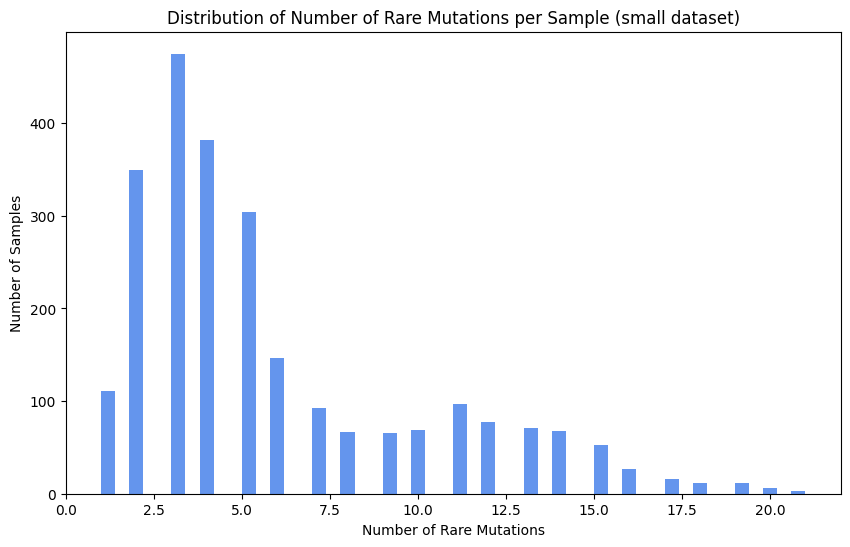

Calculating rare mutations for sample 2271 (159/667): 100%|██████████| 2504/2504 [02:28<00:00, 16.82it/s]


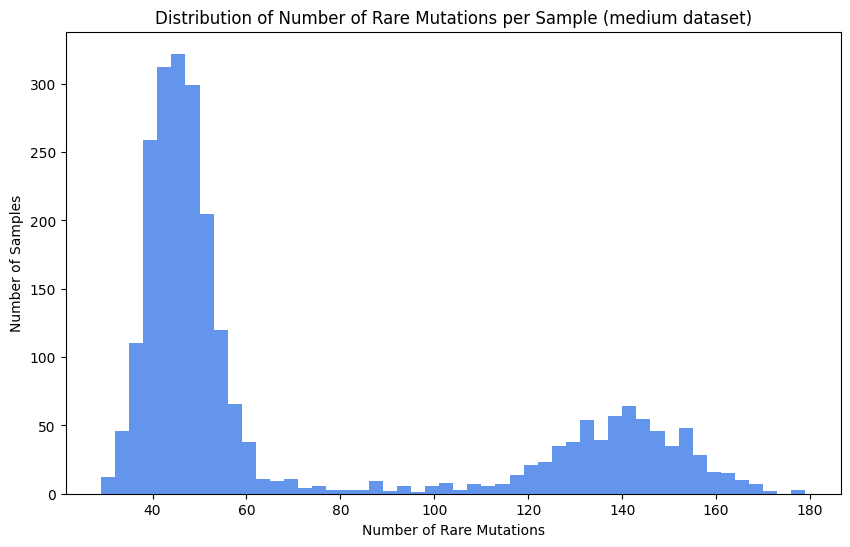

In [ ]:
# Rare Genotypes (mutated only - no 0|0 genotypes)
for dataset_size, threshold in zip(['small', 'medium'], [15, 150]):
    SOURCE_DATA_DIR = f'data/sources/json/{dataset_size}/'
    with open(f'data/sources/json/{dataset_size}/genotypes_{dataset_size}_chr22.json', 'r') as f:
        data = json.load(f)
        data = {k: v['genotypes'] for k, v in data.items()}
    
    sample_rare_genotypes = [re.findall(MUTATION_PATTERN, seq) for seq in data.values()]

    sample_names = list(data.keys())
    data_log = tqdm.tqdm(sample_rare_genotypes)
    rare_sample_gts = {sample_name: '' for sample_name in sample_names}
    
    import matplotlib.pyplot as plt
    rare_gts_lengths = []

    for j, synth_sample in enumerate(data_log):
        sample_rare_mutations = [mut.split('_')[0] for mut in synth_sample]
        common_muts = set(sample_rare_mutations).intersection(set(rare_snps))
        common_muts_with_gts = [mut for mut in synth_sample if mut.split('_')[0] in common_muts]
        rare_gts_lengths.append(len(common_muts_with_gts))
        if len(common_muts_with_gts) >= threshold:
            data_log.set_description(desc=f"Calculating rare mutations for sample {j+1} ({len(common_muts_with_gts)}/{len(synth_sample)})")
            rare_sample_gts[sample_names[j]] = ' '.join(list(common_muts_with_gts))

    plt.figure(figsize=(10, 6))
    plt.hist(rare_gts_lengths, bins=50, color='cornflowerblue')
    plt.title(f'Distribution of Number of Rare Mutations per Sample ({dataset_size} dataset)')
    plt.ylabel('Number of Samples')
    plt.xlabel('Number of Rare Mutations')
    plt.savefig(f'figures/source_data/rare_muts_distribution_{dataset_size}_dataset.pdf', format='pdf')
    plt.show()

    with open(f'data/sources/json/{dataset_size}/high_risk_profiles_{dataset_size}_chr22.json', 'w+') as f:
        json.dump(rare_sample_gts, f)

___

# 3. Random Mutation Dataset 
For benchmarking/baseline evaluation.


**VCF Template**

```
##fileformat=VCFv4.2
##source=SyntheticGenomicDPGenerator
##reference=GRCh38
#CHROM  POS     ID        REF ALT QUAL FILTER INFO FORMAT SAMPLE1 SAMPLE2 ...
chr22   16050075 rs123456 A   G   .    PASS   .    GT     0|1     1|1
```

In [20]:
from importlib import reload
import data.data_utils as data_utils
reload(data_utils)
import data.data_utils
from data.data_utils import *

In [21]:
random_corpus = generate_random_vcf(num_samples=100, 
                                    num_mutations=1000, 
                                    save=True, to_VCF=True)

Gathering mutation information from corpus: 100%|██████████| 100/100 [00:00<00:00, 618.41it/s]


Found 1000 unique mutations in 1 chromosomes.


Writing mutations to VCF: 1000it [00:00, 2130.59it/s]


Generated VCF saved to 'data/generated/vcfs/random/RandomModel.chr22.100_samples.vcf'.
Generated corpus saved to 'data/generated/json/random/rand_corpus_chr22_100ids_1000muts.json'.


In [22]:
random_corpus = generate_random_vcf(num_samples=2504, 
                                    num_mutations=1000, 
                                    save=True, to_VCF=True)

Generating 1000 random mutations for 2504 samples: 100%|██████████| 1000/1000 [00:05<00:00, 170.48it/s]
Gathering mutation information from corpus: 100%|██████████| 2504/2504 [00:04<00:00, 621.36it/s]


Found 1000 unique mutations in 1 chromosomes.


Writing mutations to VCF: 1000it [03:11,  5.23it/s]


Generated VCF saved to 'data/generated/vcfs/random/RandomModel.chr22.2504_samples.vcf'.
Generated corpus saved to 'data/generated/json/random/rand_corpus_chr22_2504ids_1000muts.json'.
